In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [125]:
df = pd.read_excel('scraper_imdbmovies.xlsx')

In [126]:
print(df.shape)
print(df.info())
print(df.head())

(1000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                1000 non-null   int64  
 1   Title               1000 non-null   object 
 2   Genre               1000 non-null   object 
 3   Description         1000 non-null   object 
 4   Director            1000 non-null   object 
 5   Actors              1000 non-null   object 
 6   Year                1000 non-null   int64  
 7   Runtime (Minutes)   1000 non-null   int64  
 8   Rating              1000 non-null   float64
 9   Votes               1000 non-null   int64  
 10  Revenue (Millions)  872 non-null    float64
 11  Metascore           936 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 93.9+ KB
None
   Rank                    Title                     Genre  \
0     1  Guardians of the Galaxy   Action,Adventure,Sci-Fi   
1    

In [127]:
print(df.isnull().sum())

Rank                    0
Title                   0
Genre                   0
Description             0
Director                0
Actors                  0
Year                    0
Runtime (Minutes)       0
Rating                  0
Votes                   0
Revenue (Millions)    128
Metascore              64
dtype: int64


In [128]:
df.dropna(inplace=True)


In [129]:
df['Revenue (Millions)'] = df['Revenue (Millions)'].fillna(df['Revenue (Millions)'].median())
df['Metascore'] = df['Metascore'].fillna(df['Metascore'].median())

In [130]:
df['Year'] = df['Year'].astype(int)
df['Runtime (Minutes)'] = df['Runtime (Minutes)'].astype(int)

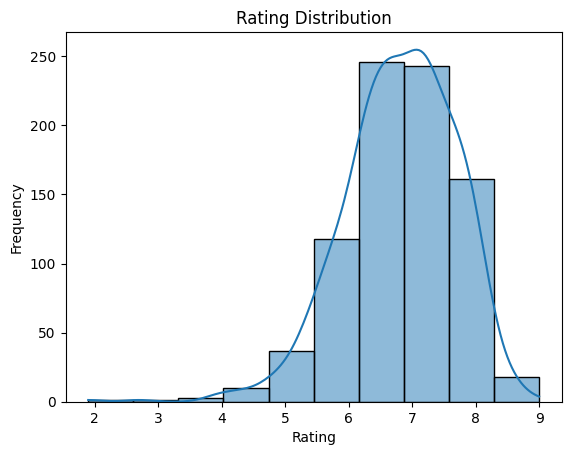

In [131]:
sns.histplot(df['Rating'], bins=10, kde=True)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()


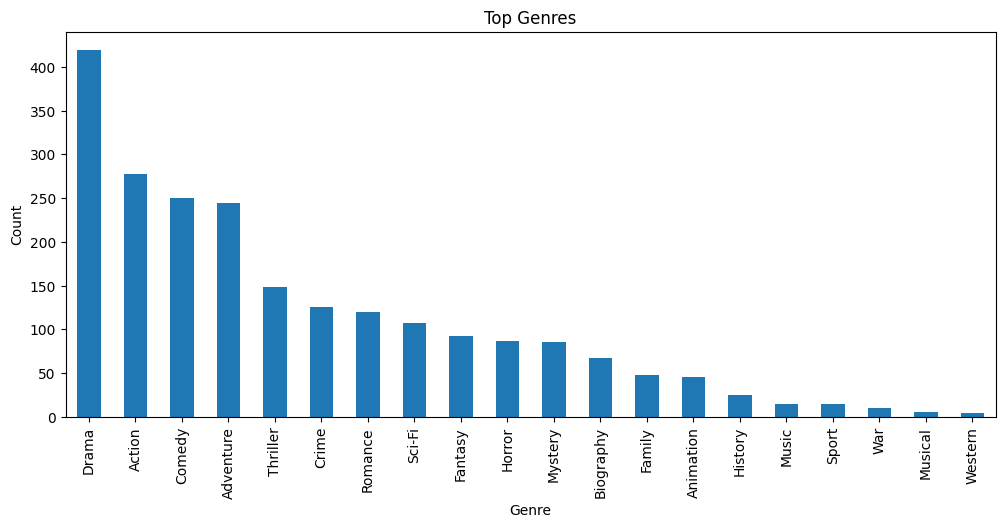

In [132]:
df['Genre'].str.split(',').explode().value_counts().plot(kind='bar', figsize=(12, 5), title="Top Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()


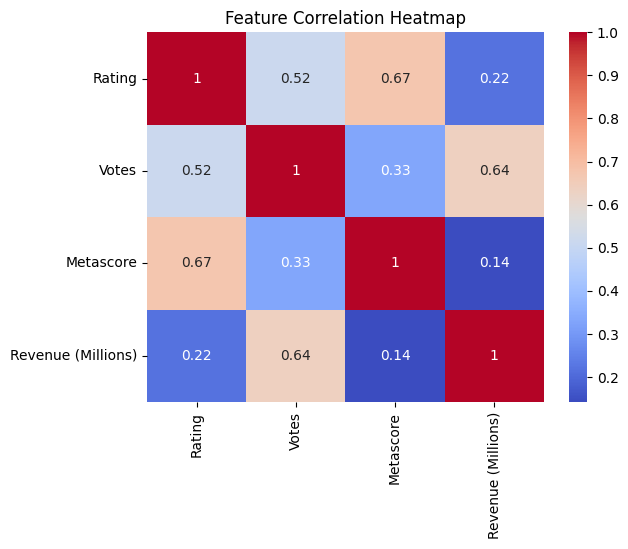

In [133]:
sns.heatmap(df[['Rating', 'Votes', 'Metascore', 'Revenue (Millions)']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


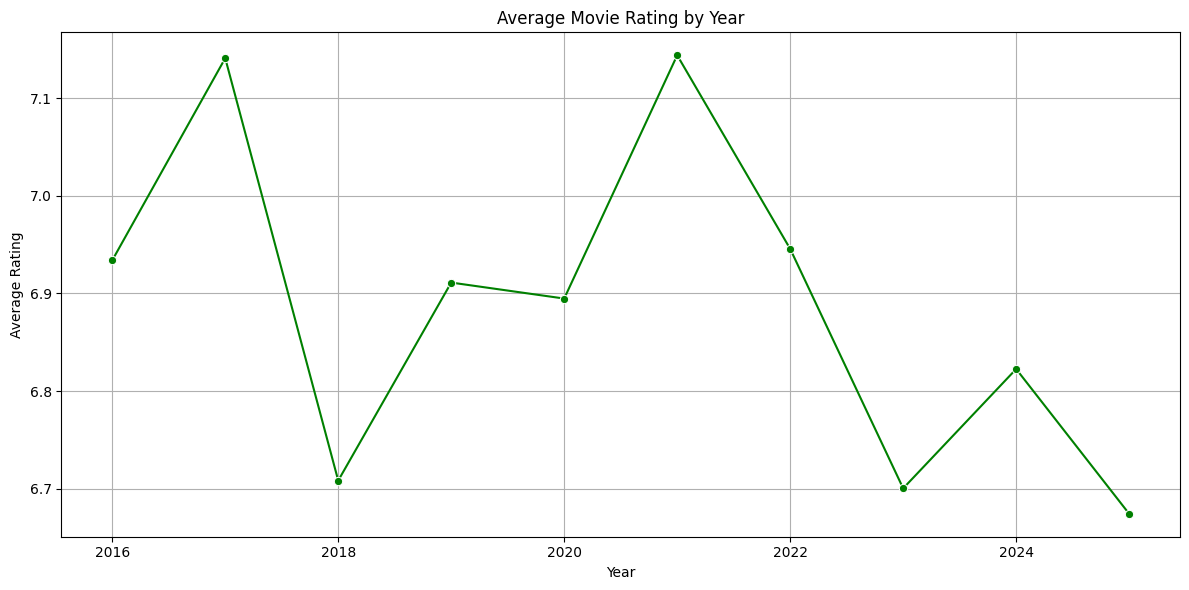

In [134]:
def ratings_over_time():
    year_rating = df.groupby('Year')['Rating'].mean().reset_index()
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=year_rating, x='Year', y='Rating', marker='o', color='green')
    plt.title("Average Movie Rating by Year")
    plt.ylabel("Average Rating")
    plt.xlabel("Year")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

ratings_over_time()


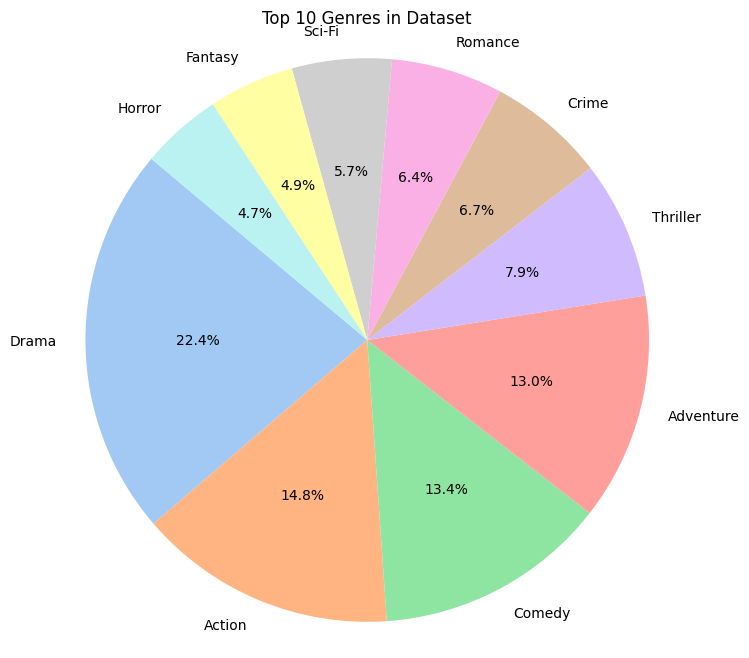

In [135]:
def genre_pie_chart():
    genre_series = df['Genre'].dropna().str.split(',').explode().str.strip()
    genre_counts = genre_series.value_counts().head(10) 

    plt.figure(figsize=(8, 8))
    plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    plt.title("Top 10 Genres in Dataset")
    plt.axis('equal')
    plt.show()

genre_pie_chart()


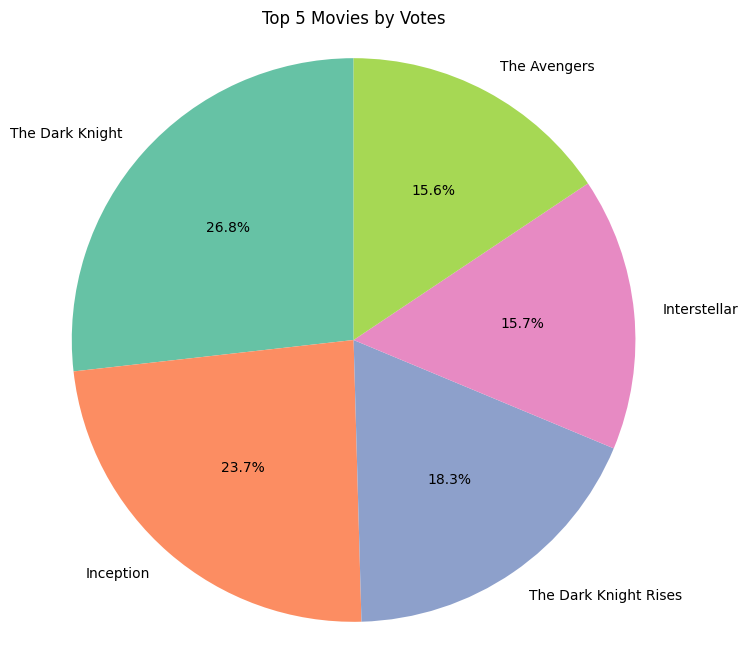

In [136]:
def vote_pie_chart():
    top_movies = df.sort_values(by='Votes', ascending=False).head(5)

    plt.figure(figsize=(8, 8))
    plt.pie(top_movies['Votes'], labels=top_movies['Title'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
    plt.title("Top 5 Movies by Votes")
    plt.axis('equal')
    plt.show()

vote_pie_chart()


C:\Users\Sonali\AppData\Local\Temp\ipykernel_12548\949829208.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_movies, x='Title', y='Runtime (Minutes)', palette='magma')


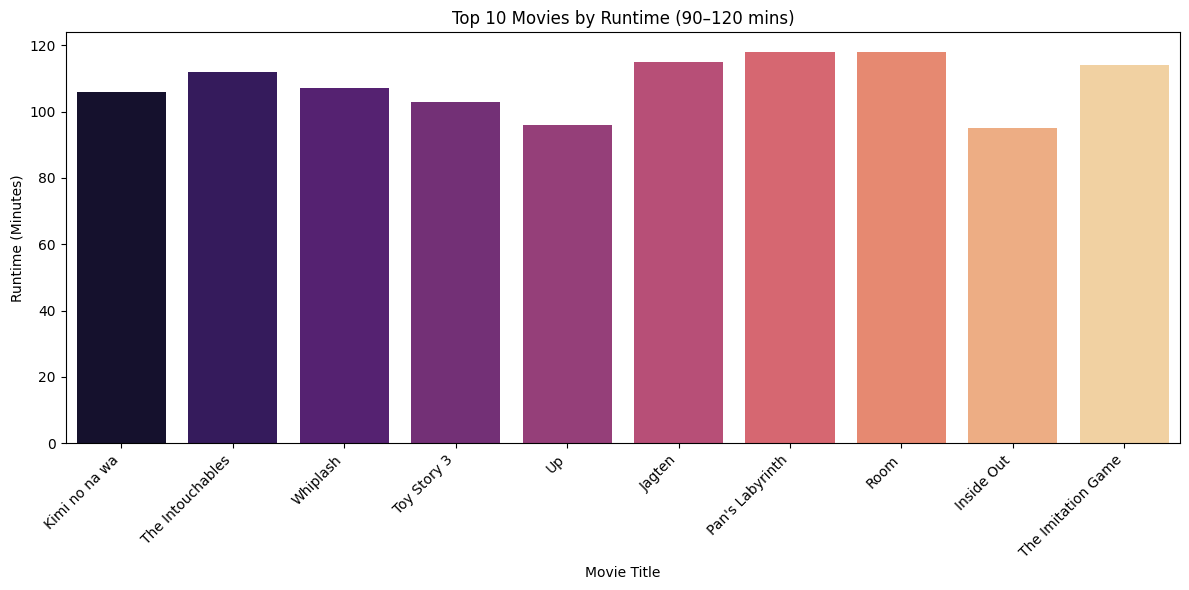

,Title,Runtime (Minutes),Rating
96,Kimi no na wa,106,8.6
249,The Intouchables,112,8.6
133,Whiplash,107,8.5
688,Toy Story 3,103,8.3
499,Up,96,8.3
455,Jagten,115,8.3
230,Pan's Labyrinth,118,8.2
143,Room,118,8.2
241,Inside Out,95,8.2
198,The Imitation Game,114,8.1


In [137]:
def recommend_by_runtime(min_time=90, max_time=120):
    filtered = df[(df['Runtime (Minutes)'] >= min_time) & (df['Runtime (Minutes)'] <= max_time)]
    top_movies = filtered.sort_values(by='Rating', ascending=False)[['Title', 'Runtime (Minutes)', 'Rating']].head(10)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_movies, x='Title', y='Runtime (Minutes)', palette='magma')
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Movies by Runtime (90–120 mins)')
    plt.ylabel('Runtime (Minutes)')
    plt.xlabel('Movie Title')
    plt.tight_layout()
    plt.show()

    return top_movies

recommend_by_runtime()


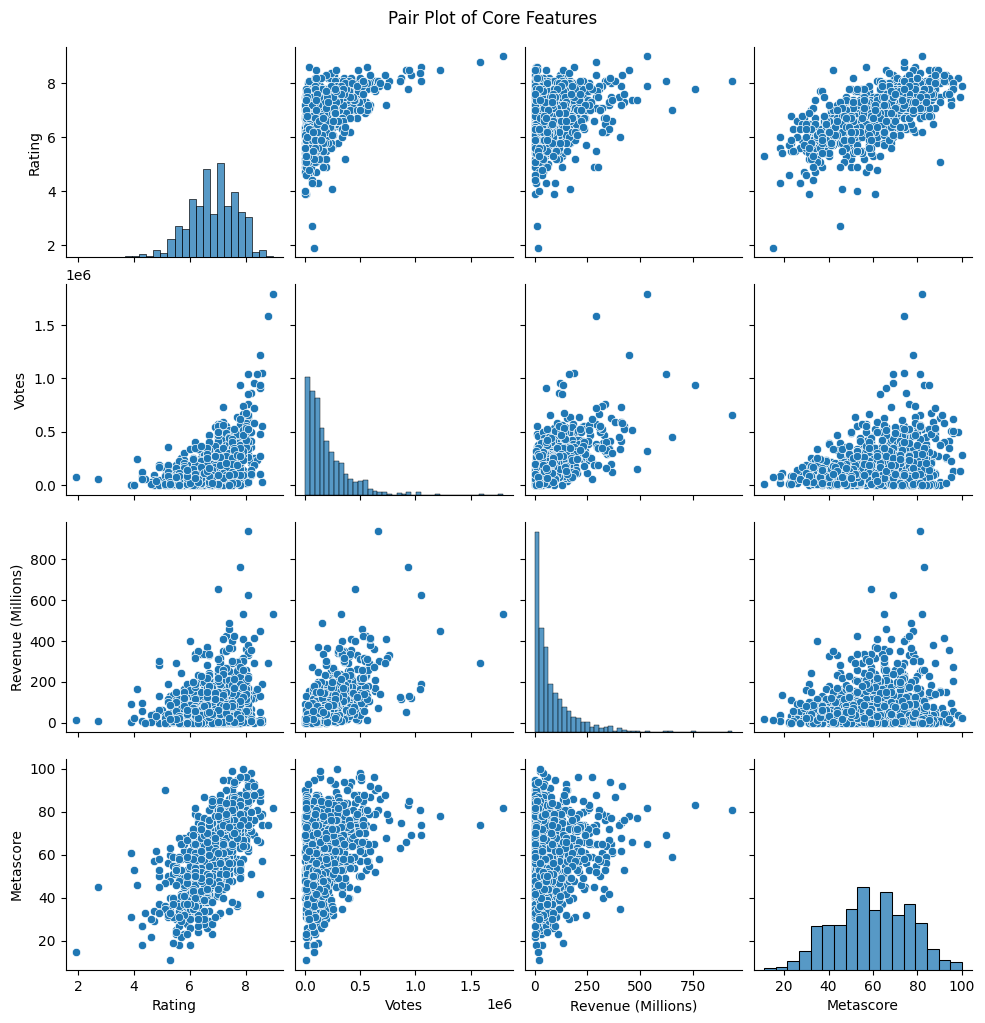

In [139]:
sns.pairplot(df[['Rating', 'Votes', 'Revenue (Millions)', 'Metascore']])
plt.suptitle("Pair Plot of Core Features", y=1.02)
plt.show()


In [140]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
df['Description'] = df['Description'].fillna('')

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Description'])

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


In [141]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

features = df[['Rating', 'Votes', 'Metascore', 'Revenue (Millions)']]
features = features.fillna(0)

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

collab_sim = cosine_similarity(scaled_features, scaled_features)


In [142]:
hybrid_sim = (cosine_sim + collab_sim) / 2


In [143]:
indices = pd.Series(df.index, index=df['Title']).drop_duplicates()

def recommend(title, sim_matrix=hybrid_sim):
    idx = indices[title]
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]
    movie_indices = [i[0] for i in sim_scores]
    return df['Title'].iloc[movie_indices]


In [144]:
print("Content-Based:")
print(recommend("Inception", sim_matrix=cosine_sim))

print("Collaborative:")
print(recommend("Inception", sim_matrix=collab_sim))

print("Hybrid:")
print(recommend("Inception"))


Content-Based:
150                                       The BFG
76                                   The Avengers
921         Scouts Guide to the Zombie Apocalypse
806           Prince of Persia: The Sands of Time
50     Star Wars: Episode VII - The Force Awakens
Name: Title, dtype: object
Collaborative:
684           Seven Pounds
498    Law Abiding Citizen
753         This Means War
215          Gods of Egypt
424      London Has Fallen
Name: Title, dtype: object
Hybrid:
921    Scouts Guide to the Zombie Apocalypse
806      Prince of Persia: The Sands of Time
621                     Underworld Awakening
5                             The Great Wall
749           Percy Jackson: Sea of Monsters
Name: Title, dtype: object


In [145]:
print(recommend("Inception", sim_matrix=cosine_sim))     
print(recommend("Inception", sim_matrix=collab_sim))     
print(recommend("Inception"))                             

150                                       The BFG
76                                   The Avengers
921         Scouts Guide to the Zombie Apocalypse
806           Prince of Persia: The Sands of Time
50     Star Wars: Episode VII - The Force Awakens
Name: Title, dtype: object
684           Seven Pounds
498    Law Abiding Citizen
753         This Means War
215          Gods of Egypt
424      London Has Fallen
Name: Title, dtype: object
921    Scouts Guide to the Zombie Apocalypse
806      Prince of Persia: The Sands of Time
621                     Underworld Awakening
5                             The Great Wall
749           Percy Jackson: Sea of Monsters
Name: Title, dtype: object


In [147]:
df['Relevant'] = df['Rating'] >= 6.5

In [148]:
def recommend(title, sim_matrix):
    idx = indices[title]
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]
    movie_indices = [i[0] for i in sim_scores]
    return df['Title'].iloc[movie_indices]


In [149]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



Content-Based Filter:
Precision: 1.00
Recall:    0.01
F1 Score:  0.02


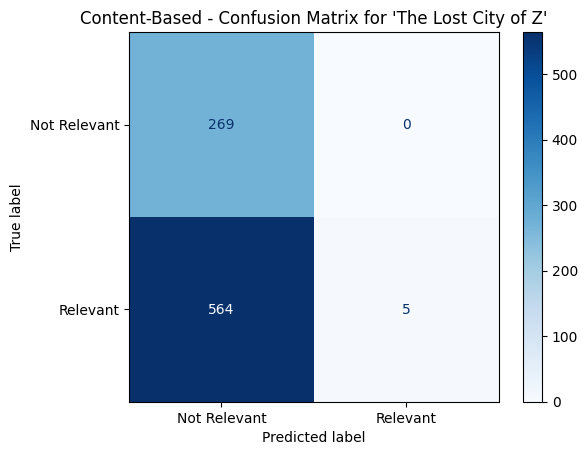


Collaborative Filter:
Precision: 0.40
Recall:    0.00
F1 Score:  0.01


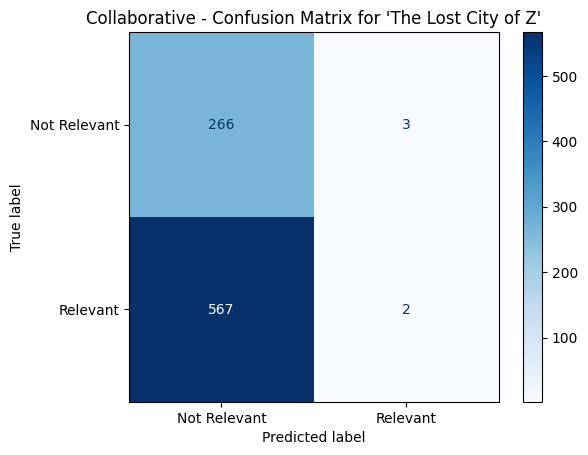


Hybrid Filter:
Precision: 1.00
Recall:    0.01
F1 Score:  0.02


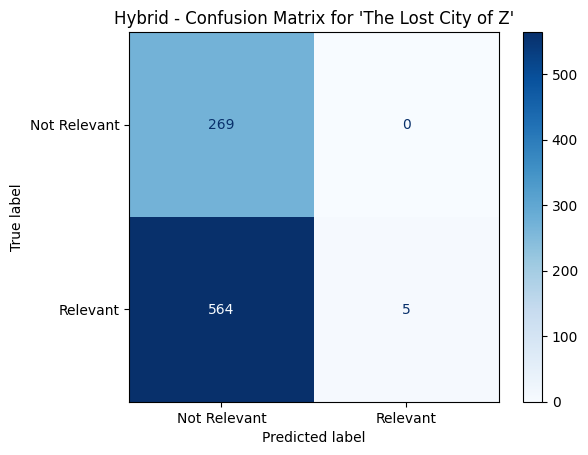

In [150]:
filters = [("Content-Based", cosine_sim), 
           ("Collaborative", collab_sim), 
           ("Hybrid", hybrid_sim)]

for name, matrix in filters:
    recommended_titles = recommend("The Lost City of Z", sim_matrix=matrix)
    
    df['Predicted'] = df['Title'].isin(recommended_titles)
    y_true = df['Relevant']
    y_pred = df['Predicted']
    
    print(f"\n{name} Filter:")
    print(f"Precision: {precision_score(y_true, y_pred):.2f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.2f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.2f}")
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Relevant", "Relevant"])
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix for 'The Lost City of Z'")
    plt.show()


In [151]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt


In [152]:
df['Relevant'] = df['Rating'] >= 6.5


In [153]:
movie_examples = ["Avatar", "The Prestige", "The Lost City of Z"]
filters = [
    ("Content-Based", cosine_sim),
    ("Collaborative", collab_sim),
    ("Hybrid", hybrid_sim)
]


In [154]:
for movie in movie_examples:
    print(f"\n Evaluating for Movie: '{movie}'\n" + "-"*40)

    for name, matrix in filters:
        recommended_titles = recommend(movie, sim_matrix=matrix)
        df['Predicted'] = df['Title'].isin(recommended_titles)



 Evaluating for Movie: 'Avatar'
----------------------------------------

 Evaluating for Movie: 'The Prestige'
----------------------------------------

 Evaluating for Movie: 'The Lost City of Z'
----------------------------------------


In [155]:
y_true = df['Relevant']
y_pred = df['Predicted']

In [156]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


In [157]:
print(f"{name} Filter:")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

Hybrid Filter:
Precision: 1.00
Recall:    0.01
F1 Score:  0.02


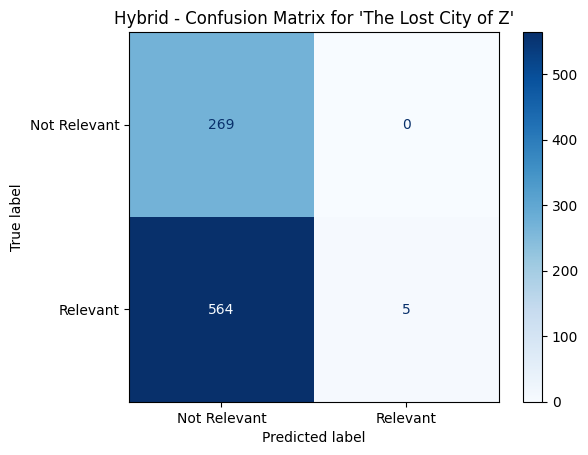

In [158]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Relevant", "Relevant"])
disp.plot(cmap='Blues')
plt.title(f"{name} - Confusion Matrix for '{movie}'")
plt.show()

In [159]:
results = []

for movie in ["Avatar", "The Prestige", "The Lost City of Z"]:
    for name, matrix in [("Content-Based", cosine_sim), 
                         ("Collaborative", collab_sim), 
                         ("Hybrid", hybrid_sim)]:
        
        recommended_titles = recommend(movie, sim_matrix=matrix)
        df['Predicted'] = df['Title'].isin(recommended_titles)
        y_true = df['Relevant']
        y_pred = df['Predicted']

        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        results.append({
            'Movie': movie,
            'Filter': name,
            'Precision': round(precision, 2),
            'Recall': round(recall, 2),
            'F1 Score': round(f1, 2)
        })


In [160]:
results_df = pd.DataFrame(results)
print(results_df)


                Movie         Filter  Precision  Recall  F1 Score
0              Avatar  Content-Based        0.6    0.01      0.01
1              Avatar  Collaborative        0.6    0.01      0.01
2              Avatar         Hybrid        0.6    0.01      0.01
3        The Prestige  Content-Based        0.8    0.01      0.01
4        The Prestige  Collaborative        1.0    0.01      0.02
5        The Prestige         Hybrid        1.0    0.01      0.02
6  The Lost City of Z  Content-Based        1.0    0.01      0.02
7  The Lost City of Z  Collaborative        0.4    0.00      0.01
8  The Lost City of Z         Hybrid        1.0    0.01      0.02


In [162]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(stop_words='english')
df['Description'] = df['Description'].fillna('')
tfidf_matrix = tfidf.fit_transform(df['Description'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

indices = pd.Series(df.index, index=df['Title']).drop_duplicates()

def recommend_movies(title, top_n=5):
    if title not in indices:
        return []
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1] 
    movie_indices = [i[0] for i in sim_scores]
    return df['Title'].iloc[movie_indices].tolist()


In [163]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import ndcg_score, average_precision_score
import numpy as np

def evaluate_recommendation(test_movie):
    recommended_movies = recommend_movies(test_movie)
    
    df['Relevant'] = df['Rating'] >= 8
    relevant_titles = df[df['Relevant']]['Title'].values

    y_true = [1 if movie in relevant_titles else 0 for movie in recommended_movies]
    y_pred = [1] * len(y_true)
    while len(y_true) < 5:
        y_true.append(0)
        y_pred.append(0)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)

    ndcg = ndcg_score([y_true], [y_pred])
    map_score = average_precision_score(y_true, y_pred)

    print(f"Movie: {test_movie}")
    print("Confusion Matrix:\n", cm)
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"NDCG: {ndcg:.2f}")
    print(f"MAP: {map_score:.2f}")
    print("-" * 40)

evaluate_recommendation("Inception")
evaluate_recommendation("The Lost City of Z")
evaluate_recommendation("The Prestige")


Movie: Inception
Confusion Matrix:
 [[0 3]
 [0 2]]
Accuracy: 0.40
Precision: 0.40
Recall: 1.00
F1 Score: 0.57
NDCG: 0.72
MAP: 0.40
----------------------------------------
Movie: The Lost City of Z
Confusion Matrix:
 [[0 4]
 [0 1]]
Accuracy: 0.20
Precision: 0.20
Recall: 1.00
F1 Score: 0.33
NDCG: 0.59
MAP: 0.20
----------------------------------------
Movie: The Prestige
Confusion Matrix:
 [[0 4]
 [0 1]]
Accuracy: 0.20
Precision: 0.20
Recall: 1.00
F1 Score: 0.33
NDCG: 0.59
MAP: 0.20
----------------------------------------


In [164]:
results = []
def evaluate_and_store_metrics(test_movie):
    recommended_movies = recommend_movies(test_movie)
    df['Relevant'] = df['Rating'] >= 6.5
    relevant_titles = df[df['Relevant']]['Title'].values

    y_true = [1 if movie in relevant_titles else 0 for movie in recommended_movies]
    y_pred = [1] * len(y_true)

    while len(y_true) < 5:
        y_true.append(0)
        y_pred.append(0)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if sum(y_true) == 0:
        print(f"No relevant movies found for {test_movie}. Skipping...")
        return None

    metrics = {
        "Movie": test_movie,
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, zero_division=0),
        "Accuracy": accuracy_score(y_true, y_pred),
        "NDCG": ndcg_score([y_true], [y_pred]),
        "MAP": average_precision_score(y_true, y_pred)
    }

    return metrics
results = []

for movie in ["Inception", "The Prestige", "The Lost City of Z"]:
    result = evaluate_and_store_metrics(movie)
    if result:
        results.append(result)

df_metrics = pd.DataFrame(results)
print(df_metrics)



                Movie  Precision  Recall  F1-Score  Accuracy      NDCG  MAP
0           Inception        0.6     1.0  0.750000       0.6  0.830189  0.6
1        The Prestige        0.8     1.0  0.888889       0.8  0.920816  0.8
2  The Lost City of Z        1.0     1.0  1.000000       1.0  1.000000  1.0


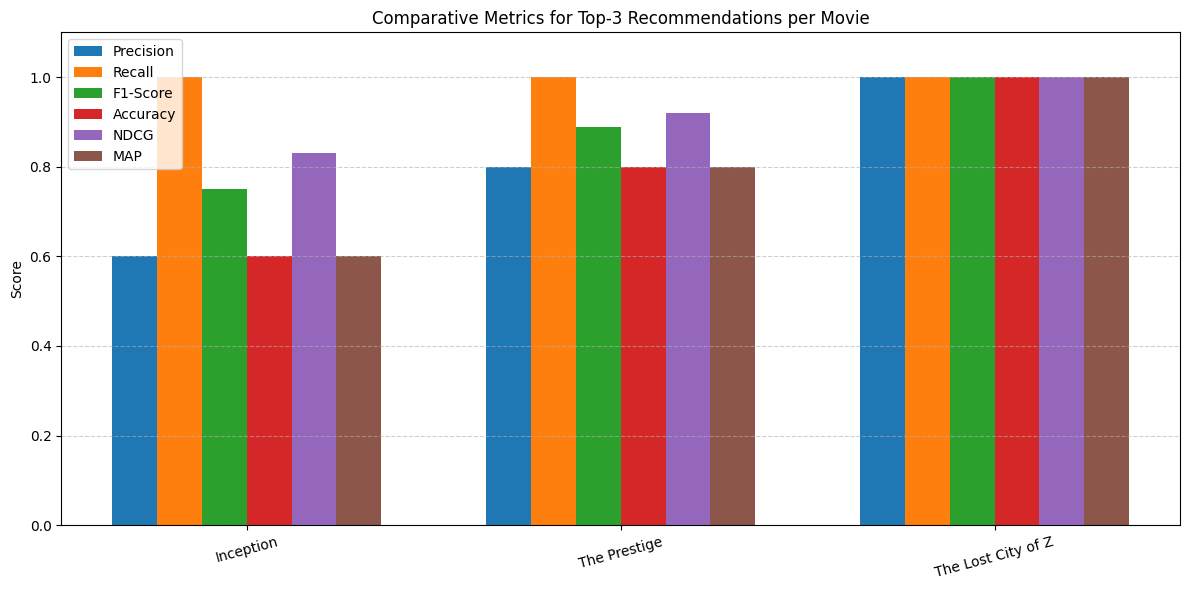

In [165]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'NDCG', 'MAP']
x = np.arange(len(df_metrics['Movie']))
bar_width = 0.12
plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics):
    plt.bar(x + (i - 2.5) * bar_width, df_metrics[metric], width=bar_width, label=metric)

plt.xticks(x, df_metrics['Movie'], rotation=15)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("Comparative Metrics for Top-3 Recommendations per Movie")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


In [166]:
results = []

def evaluate_and_store_metrics(test_movie):
    recommended_movies = recommend_movies(test_movie)
    df['Relevant'] = df['Rating'] >= 6.5
    relevant_titles = df[df['Relevant']]['Title'].values

    y_true = [1 if movie in relevant_titles else 0 for movie in recommended_movies]
    y_pred = [1] * len(y_true)

    while len(y_true) < 5:
        y_true.append(0)
        y_pred.append(0)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if sum(y_true) == 0:
        print(f"No relevant movies found for {test_movie}. Skipping...")
        return None

    metrics = {
        "Movie": test_movie,
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, zero_division=0),
        "Accuracy": accuracy_score(y_true, y_pred),
        "NDCG": ndcg_score([y_true], [y_pred]),
        "MAP": average_precision_score(y_true, y_pred)
    }

    return metrics

results = []

for movie in ["Inception", "The Prestige", "Trolls"]:
    result = evaluate_and_store_metrics(movie)
    if result:
        results.append(result)

df_metrics = pd.DataFrame(results)
print(df_metrics)



          Movie  Precision  Recall  F1-Score  Accuracy      NDCG  MAP
0     Inception        0.6     1.0  0.750000       0.6  0.830189  0.6
1  The Prestige        0.8     1.0  0.888889       0.8  0.920816  0.8
2        Trolls        0.4     1.0  0.571429       0.4  0.723136  0.4


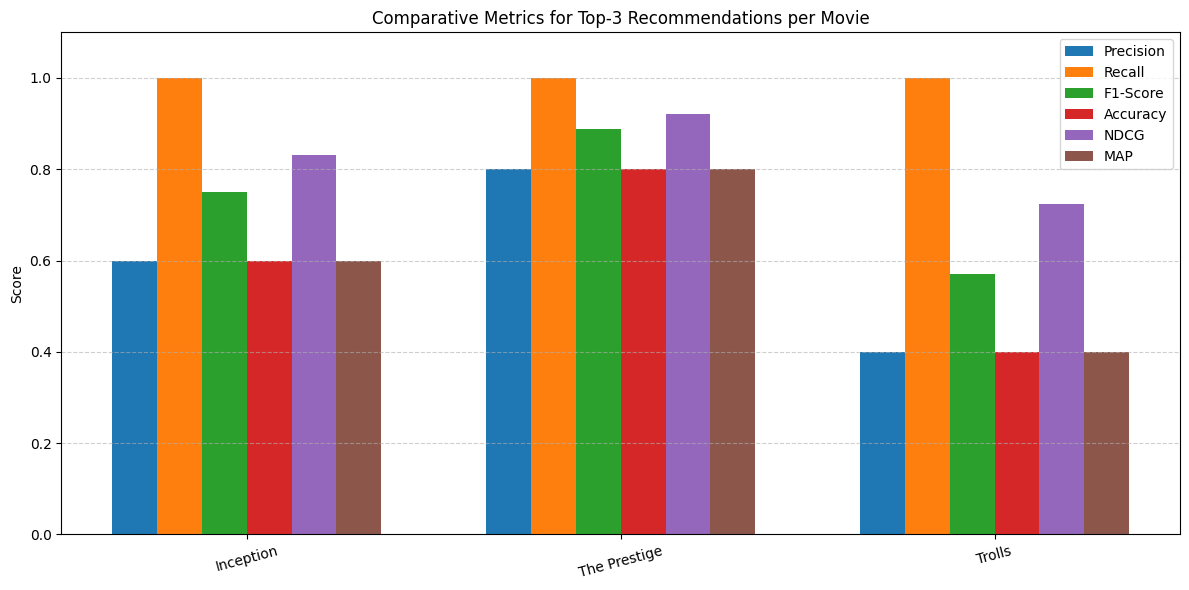

In [167]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'NDCG', 'MAP']
x = np.arange(len(df_metrics['Movie']))
bar_width = 0.12

plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics):
    plt.bar(x + (i - 2.5) * bar_width, df_metrics[metric], width=bar_width, label=metric)
    
plt.xticks(x, df_metrics['Movie'], rotation=15)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("Comparative Metrics for Top-3 Recommendations per Movie")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()
